# Classify and localize Thoracic diseases using DL!
Highlights:
1. Transfer learning using Resnet50

Plan
1. Load Data
    - Img and CSV data loaders
    - Data split
    - 
2. Preprocess 
    - Possibly augmentation
3. Run model
4. Display results
5. Localization enhancements

In [1]:
import torch
import cv2
import time
import numpy as np
import torchvision.models as models
from torch.optim import lr_scheduler
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms,utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
import os
import pandas as pd
import glob
from skimage import io
import matplotlib.pyplot as plt
import os 

%matplotlib inline
use_gpu = torch.cuda.is_available()


In [2]:
# Config
DATA_DIR = 'data'
TRAIN_DIR = 'train'
TEST_DIR = 'test'
TRAIN_DS_LOC = os.path.join(DATA_DIR, TRAIN_DIR)
TEST_DS_LOC = os.path.join(DATA_DIR, TEST_DIR)
IMG_PATTERN = '*.png'
IMG_PROPERTIES_FILE = 'Data_Entry_2017.csv'
LABEL_SEP = '|'
Height=512
Width=512
Batch_size = 12


In [3]:
# Retrieve and process labels
l2i = {'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'No Finding': 10,
 'Nodule': 11,
 'Pleural_Thickening': 12,
 'Pneumonia': 13,
 'Pneumothorax': 14}

properties = pd.read_csv(IMG_PROPERTIES_FILE, skiprows=1, header=None, low_memory=False, na_filter=False).values
labels = {prop[0] : [ l2i[label] for label in  prop[1].split(LABEL_SEP)] for prop in properties}

num_classes=len(l2i)


In [4]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
          transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}


In [5]:
def label_standard_array(labels):
    standard_class=np.zeros(shape=num_classes)
    for i in labels:
       standard_class[i]=1
    return standard_class
    

In [6]:
a= "data/train/00000324_013.png"
img = cv2.imread(a)

print(img.shape)

(512, 512, 3)


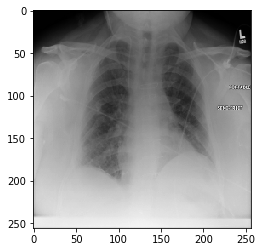

In [7]:
#def split TODO:training and test validations
class XrayFolderDS(Dataset):
    def __init__(self, root, transform = None):
        self.data = glob.glob(os.path.join(root, IMG_PATTERN))
        self.transform = transform
        # transforms.ToPILImage(),
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        entry = self.data[index]
        name = os.path.split(entry)[-1]
        img = cv2.imread(entry)
        resized_image = cv2.resize(img, (256, 256)) 
        img = self.transform(resized_image)
        labels_name=label_standard_array(labels[name])
        return img,labels_name
        
test_d = XrayFolderDS(TRAIN_DS_LOC,data_transforms['train'])[0][0]
# convert to np and remove extra dim
numpy_d = test_d.numpy()[0] 
plt.imshow(numpy_d, cmap='gray') # Remove gray for green normalized image :D
plt.show()

In [8]:
# Hyperparameters
BATCH_SIZE = 10


In [9]:
# Prepare Data
# print( [d for d in os.listdir(TRAIN_DS_LOC) ] )

#print(os.getcwd()+'\\data\\train\\', torchvision.datasets.folder.find_classes('data/train'))
train_dataset = XrayFolderDS(TRAIN_DS_LOC,data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader_2=train_dataloader
test_dataset = XrayFolderDS(TEST_DS_LOC,data_transforms['train'])
test_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataloaders={'train':train_dataloader,'test':test_dataloader}
dataset_sizes = {'train':len(train_dataset),'test':len(train_dataset)}

# test_dataset = XrayFolderDS(TRAIN_DS_LOC,data_transforms['test'])
# test_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# TODO: Implement k fold cross validation


('Batch Number', 0)
('Batch Number', 1)
('Batch Number', 2)
('Batch Number', 3)
('Batch Number', 4)
('Batch Number', 5)
('labels_batch batch size', torch.Size([10, 15]))
10


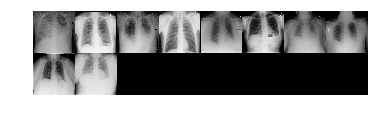

In [10]:
def show_xray_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    xrays_batch,labels_batch = sample_batched
    print('labels_batch batch size',labels_batch.shape)
    print(len(labels_batch))
    grid_1 = utils.make_grid(xrays_batch)
    plt.imshow(grid_1.numpy().transpose(( 1,2, 0)))


for i_batch, sample_batched in enumerate(train_dataloader_2):
    print ('Batch Number', i_batch)
    # observe 4th batch and stop.
    if i_batch == 5:
        plt.figure()
        show_xray_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [11]:
xray_model = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/jawa/.torch/models/resnet50-19c8e357.pth
99.5%

In [12]:
# print(xray_model)

In [13]:
num_ftrs = xray_model.fc.in_features
# changing the final_layer for our images 
xray_model.fc = nn.Linear(num_ftrs,num_classes)
print(xray_model.fc)
print(xray_model)

Linear (2048 -> 15)
ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )

In [75]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable( labels )
                
                # print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                preds = torch.sign(torch.sign(outputs.data-0.5)+1)
                # print(outputs.size())
                loss = criterion(outputs.double(), labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                
                running_loss += loss.data[0]
                # running_corrects += torch.sum(preds == labels.data)
                x=torch.sum(preds == labels.data.float(),1)
                running_corrects += torch.sum(x==num_classes)

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [76]:
a = torch.Tensor(4, 2).uniform_(0, 1)
print(a) 
preds = torch.sign(torch.sign(a-0.5)+1)
print(preds)
actual_label=torch.ones(4,2)
print(actual_label)

x=torch.sum(torch.sum(preds == actual_label,1)==2)

print('equal_array',x)



 0.6843  0.9031
 0.6094  0.6431
 0.2691  0.7226
 0.0621  0.9844
[torch.FloatTensor of size 4x2]


 1  1
 1  1
 0  1
 0  1
[torch.FloatTensor of size 4x2]


 1  1
 1  1
 1  1
 1  1
[torch.FloatTensor of size 4x2]

('equal_array', 2)


# Optimizer and Loss

In [77]:
if use_gpu:
    xray_model = xray_model.cuda()

criterion = nn.MultiLabelSoftMarginLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(xray_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [78]:
model_ft = train_model(xray_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


KeyboardInterrupt: 